In [1]:
import torch
import torch.nn.functional as F

import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from skimage.transform import resize
import torchvision.transforms as transforms
import json
import numpy as np

from math import floor, ceil

In [2]:
# Face Recognition imports
from FaceRecognition.model.model import DetectionModel
from FaceRecognition import trainer

In [24]:
def show_image(tensor, title='Plain Image'):
    numpy_img = tensor.permute(1, 2, 0).numpy()  # Change tensor shape to (height, width, channels) for plotting
    
    # Plot the image using matplotlib
    plt.imshow(numpy_img)
    plt.axis('off')  # Hide axis values
    plt.title(title)  # Set title if needed
    plt.show()

def show_image_boxes(tensor, dets):
    numpy_img = tensor.permute(1, 2, 0).numpy()  # Change tensor shape to (height, width, channels) for plotting

    fig, ax = plt.subplots()

    ax.imshow(numpy_img)

    for det in dets:
        left_bottom = (det[0], det[1])
        width, height = (det[2] - det[0], det[3] - det[1])
        rect = patches.Rectangle(left_bottom, width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

def show_image_boxes_faces(tensor, dets, faces, face_subplots=(10,10)):
    numpy_img = tensor.permute(1, 2, 0).numpy()  # Change tensor shape to (height, width, channels) for plotting
    plt.axis('off')

    fig = plt.figure(figsize=(18.4,6))
    subfigs = fig.subfigures(3, 1)
    
    for i, subfig in enumerate(subfigs.flat):
        # plot original image
        if i == 0:
            ax = subfig.subplots(1,1)
            ax.set_title('Original')
            ax.axis('off')
            ax.imshow(numpy_img)
        # plot boxes on the image
        elif i == 1:
            ax = subfig.subplots(1,1)
            ax.set_title('Boxes on Image')
            ax.imshow(numpy_img)
            ax.axis('off')

            for det in dets:
                left_bottom = (det[0], det[1])
                width, height = (det[2] - det[0], det[3] - det[1])
                rect = patches.Rectangle(left_bottom, width, height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        # show faces only
        else:
            subfig.suptitle('Faces')  # Set title if needed
            
            axs = subfig.subplots(*face_subplots)
        
            for j in range(len(faces)):
                face_img = faces[j].permute(1, 2, 0).numpy()        
                axs[j // face_subplots[1]][j % face_subplots[1]].imshow(face_img)
                axs[j // face_subplots[1]][j % face_subplots[1]].axis('off')
            
            plt.show()


def plot_faces(faces, subplots=(10,10)):
    fig, axs = plt.subplots(subplots[0], subplots[1])
    for i in range(len(faces)):
        face_img = faces[i].permute(1, 2, 0).numpy()
        axs[i//subplots[1]][i % subplots[1]].imshow(face_img)
    plt.axis('off')  # Hide axis values
    plt.title('Faces')  # Set title if needed
    plt.show()

def get_faces(tensor, dets):
    faces = []
    for det in dets:
        x_start, x_end = floor(det[0]), ceil(det[2]) + 1
        y_start, y_end = floor(det[1]), ceil(det[3]) + 1
        faces.append(tensor[:,y_start:y_end,x_start:x_end])
    return faces

def filter_dets(dets, treshold=1):
    new_dets = []
    for det in dets:
        if det[4] >= treshold:
            new_dets.append(det)
    return new_dets

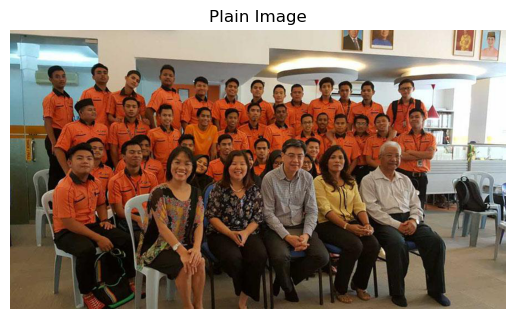

In [4]:
# load image
test_image = Image.open(os.path.join(os.getcwd(), "test_image.jpg"))
transform = transforms.ToTensor()

test_tensor = transform(test_image)

show_image(test_tensor)

In [5]:
# load face detection
face_detection_model = DetectionModel(num_templates=25)
detection_checkpoint = torch.load(os.path.join(os.getcwd(), "FaceRecognition", "weights.pth"))
face_detection_model.load_state_dict(detection_checkpoint["model"])

C:\Users\Kalami\anaconda3\envs\CA\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kalami\anaconda3\envs\CA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
# super-resolution network
sys.path.append('C:\\Users\\Kalami\\CA\\PutTogether\\SuperResolution\\model')
super_resolution_model = torch.load(os.path.join(os.getcwd(), "SuperResolution", "weights.pth"), map_location=lambda storage, loc: storage)

C:\Users\Kalami\anaconda3\envs\CA\Lib\site-packages\torch\serialization.py:1101: SourceChangeWarning: source code of class 'GAN_model.Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Kalami\anaconda3\envs\CA\Lib\site-packages\torch\serialization.py:1101: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Kalami\anaconda3\envs\CA\Lib\site-packages\torch\serialization.py:1101: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the obje

In [7]:
# imports for facial expression thingy
from ExpressionRecognition.models import VGG

In [8]:
# facial expression recognition
expression_model = VGG('VGG19')
expression_checkpoint = torch.load(os.path.join(os.getcwd(), "ExpressionRecognition", "weights.pth"))
expression_model.load_state_dict(expression_checkpoint)

<All keys matched successfully>

In [13]:
# Image processing for facial recognition
def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
def convert_to_facial_compatible(tensor):
    cut_size = 44

    transform_test = transforms.Compose([
        transforms.TenCrop(cut_size),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    ])

    tensor = tensor.permute(1, 2, 0).numpy()
    tensor = rgb2gray(tensor)
    tensor = resize(tensor, (48,48), mode='symmetric')
    tensor = np.floor(tensor * 255).astype(np.uint8)
    tensor = tensor[:, :, np.newaxis]    
    tensor = np.concatenate((tensor, tensor, tensor), axis=2)
    img = Image.fromarray(tensor)
    return transform_test(img)

def facial_compatible_to_inputs(inputs):
    ncrops, c, h, w = np.shape(inputs)
    
    inputs = inputs.view(-1, c, h, w)
    return inputs, ncrops

# Process facial recognition output
def outputs_to_result(outputs, ncrops):
    outputs_avg = outputs.view(ncrops, -1).mean(0)  # avg over crops
    
    score = F.softmax(outputs_avg, -1)
    return score

def prediction_from_score(score):
    _, predicted = torch.max(score.data, 0)
    return predicted

In [1]:
# load templates; run stuff
rf = {
    'size': [859, 859],
    'stride': [8, 8],
    'offset': [-1, -1]
}

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
templates = json.load(open(os.path.join(os.getcwd(), "FaceRecognition", "datasets", "templates.json")))
templates = np.round_(np.array(templates), decimals=8)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

with torch.no_grad():
    # upscaled_tensor = super_resolution_model(test_tensor.unsqueeze(0))
    
    dets = trainer.get_detections(face_detection_model, test_tensor.unsqueeze(0), templates, rf, val_transforms, 0.03,
                                      0.3, device='cuda')
    dets = filter_dets(dets)
    faces = get_faces(test_tensor, dets)

    faces = [super_resolution_model(face.unsqueeze(0)).squeeze() for face in faces]
    # faces = [F.interpolate(face.unsqueeze(0), scale_factor=2, mode='bilinear', align_corners=True).squeeze() for face in faces]
    
    results = torch.zeros(7)
    for face in faces:
        inputs = convert_to_facial_compatible(face)
        inputs, ncrops = facial_compatible_to_inputs(inputs)
        outputs = expression_model(inputs)
        score = outputs_to_result(outputs, ncrops)
        predicted = prediction_from_score(score)
        results += score        
        
    show_image(test_tensor, f"Emotion of the crowd: {class_names[int(prediction_from_score(results).numpy())]}")
    show_image_boxes(test_tensor, dets)
    print(results, prediction_from_score(results))


NameError: name 'transforms' is not defined